# Task 2: Predicting customer buying behaviour
## 4. Feature selection

## Import libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

## Load the data

In [41]:
df = pd.read_pickle("df_transformed.pickle")

## Supervised methods

#### Separate x and y

In [42]:
target = "booking_complete"
x = df.drop(columns=target).copy()
y = df[target].copy()

### Mutual information

#### Create a function to show the results

In [43]:
def ranking_mi(mutual_selector, mode = 'table'):
    #Create the ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importance_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importance_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Shows the output
    if mode == 'table':
        return(ranking_mi)
    else:
        g = ranking_mi.importance_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importance_mi').variable)
        return(g)

#### Calculate and show the output

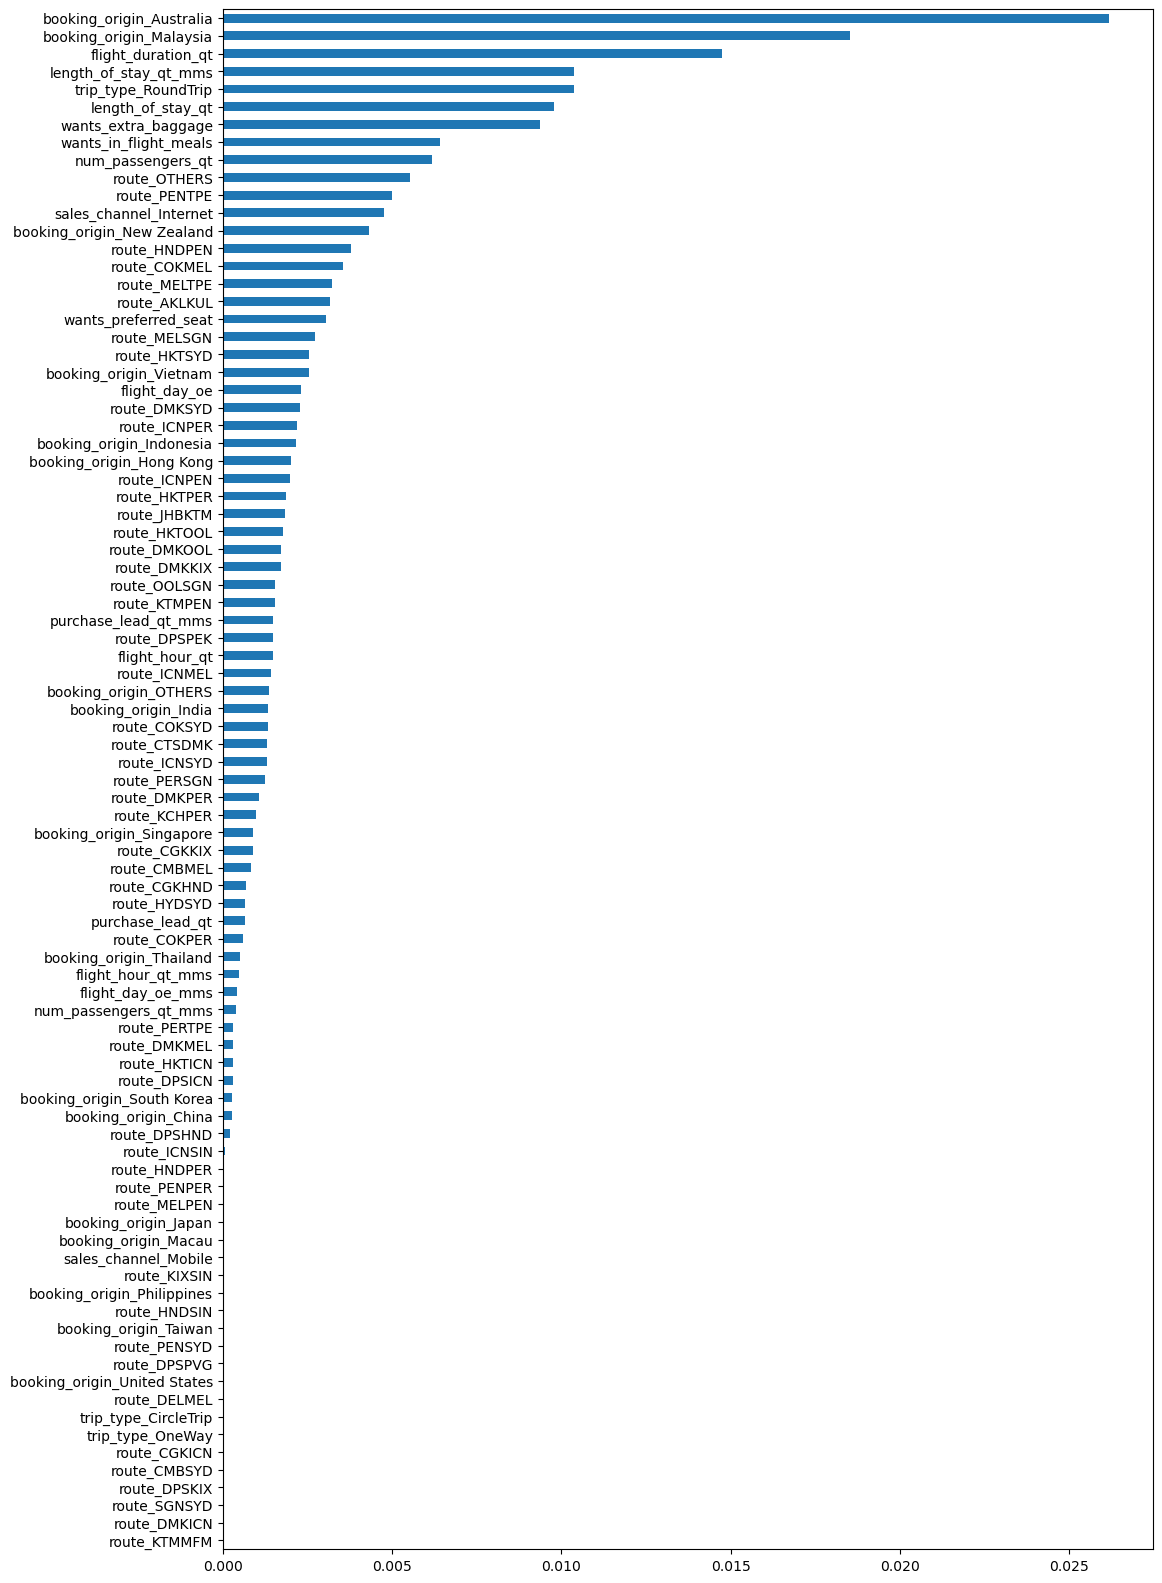

In [44]:
mutual_selector = mutual_info_classif(x,y)

rank_mi = ranking_mi(mutual_selector, mode = 'plot')

### Recursive Feature Elimination

#### Instantiate

In [45]:
rfe = RFE(estimator = XGBClassifier(n_jobs = -1, eval_metric='auc'))

#### Fit

In [46]:
rfe.fit(x,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric='auc',
                            feature_types=None, gamma=None, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=-1, num_parallel_tree=None, predictor=None,
                            random_state=None, ...))

#### Show the output variables

In [47]:
entran_rfe = x.columns[rfe.support_]
entran_rfe

Index(['sales_channel_Internet', 'trip_type_RoundTrip', 'route_AKLKUL',
       'route_CGKHND', 'route_CGKKIX', 'route_CMBMEL', 'route_CMBSYD',
       'route_DELMEL', 'route_DMKKIX', 'route_DMKPER', 'route_DPSICN',
       'route_HKTICN', 'route_ICNMEL', 'route_ICNPEN', 'route_ICNPER',
       'route_ICNSIN', 'route_ICNSYD', 'route_KIXSIN', 'route_MELTPE',
       'route_OOLSGN', 'route_OTHERS', 'route_PENTPE', 'route_SGNSYD',
       'booking_origin_Australia', 'booking_origin_China',
       'booking_origin_India', 'booking_origin_Indonesia',
       'booking_origin_Japan', 'booking_origin_Macau',
       'booking_origin_Malaysia', 'booking_origin_New Zealand',
       'booking_origin_OTHERS', 'booking_origin_Philippines',
       'booking_origin_Singapore', 'booking_origin_South Korea',
       'booking_origin_Taiwan', 'booking_origin_Thailand',
       'booking_origin_Vietnam', 'length_of_stay_qt', 'flight_duration_qt',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_mea

### Permutation Importance

#### Create a function to show the results

In [48]:
def ranking_per(predictors,permutation):
    ranking_per = pd.DataFrame({'variable': predictors.columns, 'importance_per': permutation.importances_mean}).sort_values(by = 'importance_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instantiate and fit the method

In [49]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')

xgb.fit(x,y)

#Use of roc auc for the scoring method
permutation = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'roc_auc',
                                     n_repeats=5, n_jobs = -1)

c:\Users\Luis\miniconda3\envs\project_BA\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


#### Check the output

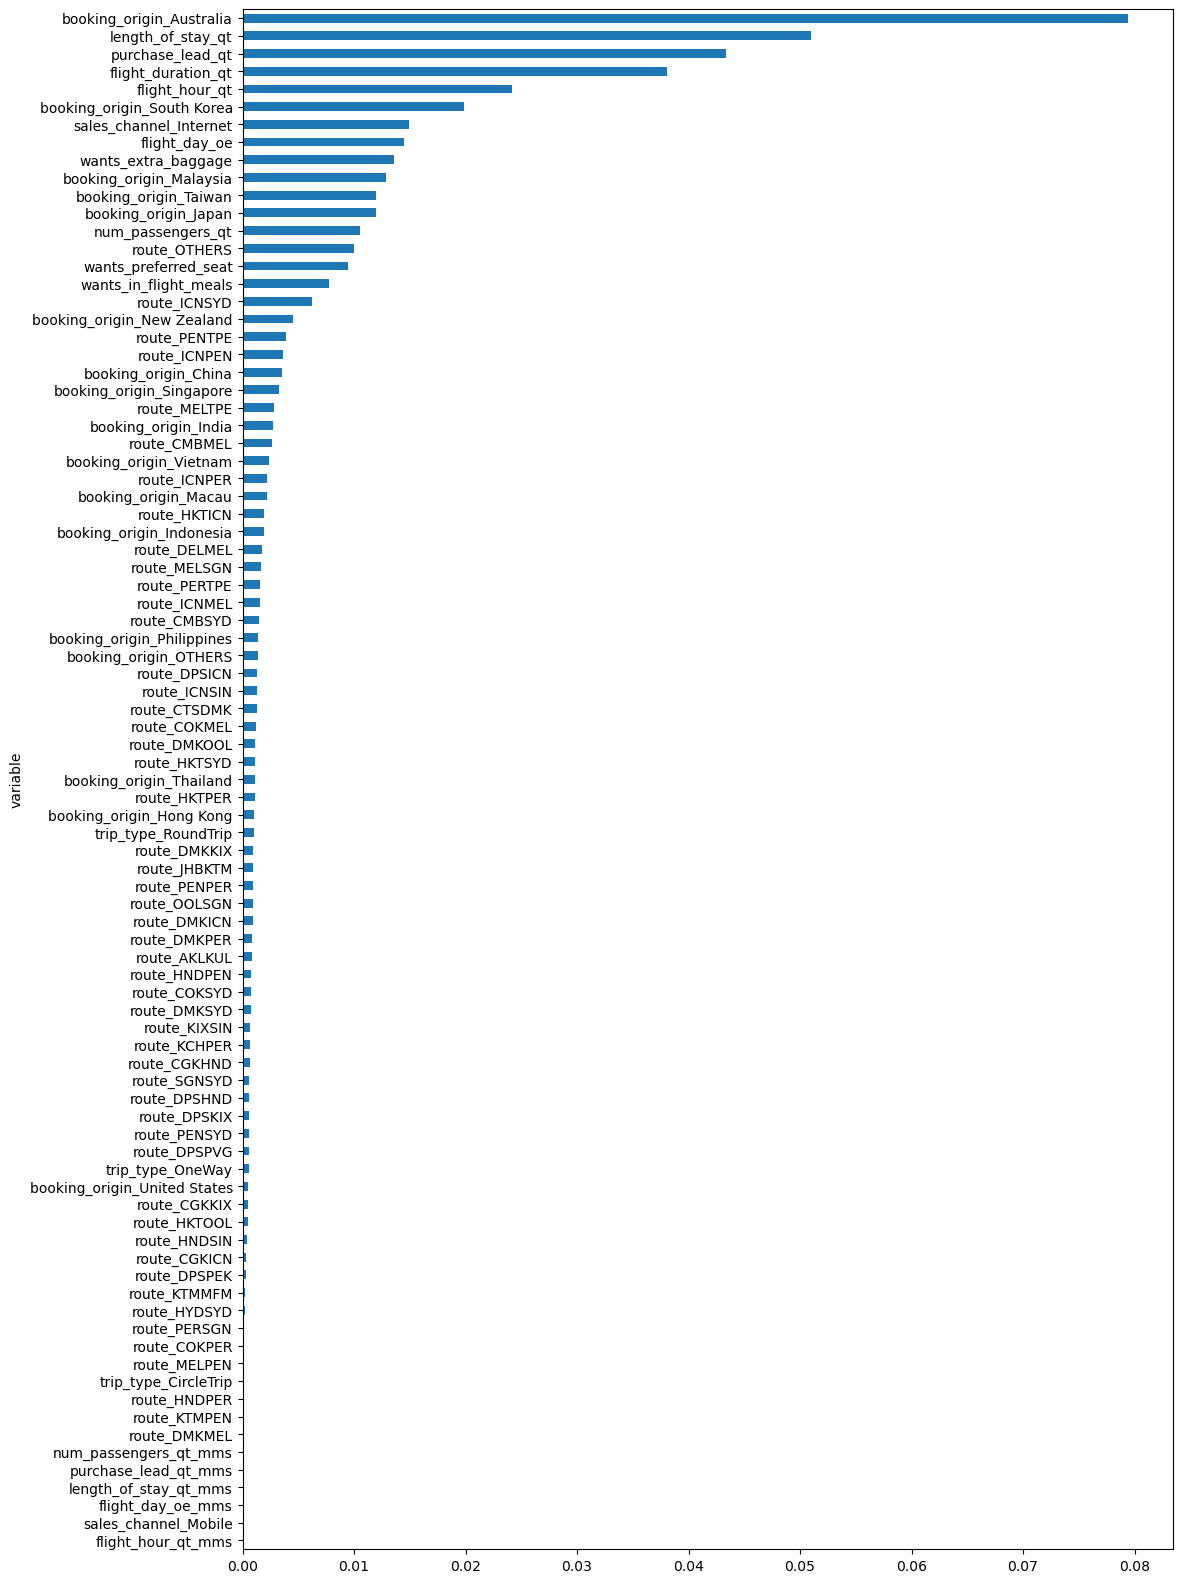

In [50]:
rank_per = ranking_per(x,permutation)

rank_per.set_index('variable').importance_per.sort_values().plot.barh(figsize = (12,20));

### Select Permutation Importance variables

Choose the name of the variables that we want to proceed with.

In [51]:
select_permutation = rank_per.iloc[0:16]["variable"]

In [52]:
x_per = x[select_permutation].copy()

## Unsupervised methods

### Correlation

### Create a function to show the output

In [53]:
# We build a function to check what variables correlate within a certain threshold
def strong_corr(df, lim_inf = 0.3, lim_sup = 1,drop_dupli=True):
    #Compute correlation matrix
    c = df.corr().abs()
    #Unstack everything (columns become rows)
    c= c.unstack()
      #Create a dataframe where index becomes a column and variables' names are defined
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1','var2','corr']
    #Filter within the determined thresholds
    c = c.loc[(c['corr'] > lim_inf) &  (c['corr'] < lim_sup),:].sort_values(by = 'corr', ascending=False)
    #Drop duplicates if drop_dupli = True
    c = c if drop_dupli == False else c.drop_duplicates(subset = ['corr'])
    #Output
    return(c)

#### Compute the output

In [54]:
cor_finales = strong_corr(x_per)

#### Check the correlations

In [55]:
cor_finales.var1.value_counts()

booking_origin_Australia    2
flight_duration_qt          1
wants_preferred_seat        1
Name: var1, dtype: int64

In [56]:
cor_finales.head(50)

,var1,var2,corr
58,flight_duration_qt,booking_origin_Taiwan,0.450689
239,wants_preferred_seat,wants_in_flight_meals,0.315162
3,booking_origin_Australia,flight_duration_qt,0.306921
9,booking_origin_Australia,booking_origin_Malaysia,0.305886


In this case we are not getting rid off any of these variables due to their predictive importance.

Save the final features in .pickle format to proceed to the next step (balancing).

In [57]:
pd.to_pickle(x_per, "x_final.pickle")

y_final = y.copy()
pd.to_pickle(y_final, "y_final.pickle")